In [1]:
import src.data
import src.lfads_helpers
import src.util
import pyaldata
import yaml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ipywidgets import interact

from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.linear_model import LinearRegression

sns.set_context('talk')

%load_ext autoreload
%autoreload 2

In [2]:
with open('../params.yaml', 'r') as params_file:
    lfads_params = yaml.safe_load(params_file)['lfads_prep']

trial_data = src.data.load_clean_data('../data/trial_data/Earl_20190716_COCST_TD.mat')
td_co = src.lfads_helpers.prep_data_with_lfads(trial_data, 'CO', lfads_params)
td_cst = src.lfads_helpers.prep_data_with_lfads(trial_data,'CST', lfads_params)

# rebin at 50 ms
td_co = pyaldata.combine_time_bins(td_co, n_bins=int(0.05/td_co['bin_size'].values[0]))
td_cst = pyaldata.combine_time_bins(td_cst, n_bins=int(0.05/td_cst['bin_size'].values[0]))

# only take rewards
td_co = td_co.groupby('result').get_group('R').copy()
td_cst = td_cst.groupby('result').get_group('R').copy()

co_epoch_fun = src.util.generate_realtime_epoch_fun(
    'idx_goCueTime',
    rel_end_time=0.5,
)
cst_epoch_fun = src.util.generate_realtime_epoch_fun(
    'idx_cstStartTime',
    rel_end_time=5.0,
)
td_co = pyaldata.restrict_to_interval(td_co,epoch_fun=co_epoch_fun)
td_cst = pyaldata.restrict_to_interval(td_cst,epoch_fun=cst_epoch_fun)


/home/raeed/miniconda3/envs/autolfads-tf2/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [  7   8  18  19  22  24  25  33  34  36  56  62  66  86  94  95 103 110
 112 115 120 123 131 137 139 146 157 159 161 162 165 173 181 187 200 218
 222 224 225 229 230 239 244 249 254 261 266 269 271 286 304 306 308 309
 316 321 334 342 344 347 351 352 355 357 360 361 366 369 370 371 373 376
 378 381 382 384 386 388 393 394 399 403 404 405 408 409 411 413 416 420
 422 423 424 426 427 428 429 431 436 437 446 447 452 454 456 458 459 460
 461 462 464 469 472 476 477 481 488 489 490 491 492 494 500 508 509 510
 512 513 516 519 534 535 536]


In [22]:
# run some decoding...
# use cross_val_score with linear model on data
# first compose new dataframe with index trial_id and columns of interest (M1_rates, lfads_rates, hand_vel)

df_co = src.util.crystallize_dataframe(td_co,sigs=['M1_rates','lfads_rates','hand_vel'])
df_cst = src.util.crystallize_dataframe(td_cst,sigs=['M1_rates','lfads_rates','hand_vel'])

In [23]:
co_smoothed_scores = cross_val_score(LinearRegression(), df_co['M1_rates'], df_co[('hand_vel',0)], cv=5, groups=df_co.reset_index()['trial_id'])
co_lfads_scores = cross_val_score(LinearRegression(), df_co['lfads_rates'], df_co[('hand_vel',0)], cv=5, groups=df_co.reset_index()['trial_id'])
cst_smoothed_scores = cross_val_score(LinearRegression(), df_cst['M1_rates'], df_cst[('hand_vel',0)], cv=5, groups=df_cst.reset_index()['trial_id'])
cst_lfads_scores = cross_val_score(LinearRegression(), df_cst['lfads_rates'], df_cst[('hand_vel',0)], cv=5, groups=df_cst.reset_index()['trial_id'])

print('CO smoothed:', co_smoothed_scores)
print('CO lfads:', co_lfads_scores)
print('CST smoothed:', cst_smoothed_scores)
print('CST lfads:', cst_lfads_scores)

CO smoothed: [0.71602962 0.69404382 0.67259853 0.50254745 0.53792002]
CO lfads: [0.79427078 0.86513869 0.80658433 0.81677465 0.7501981 ]
CST smoothed: [0.41049521 0.5046371  0.5356095  0.56020755 0.55854403]
CST lfads: [0.56623208 0.63839552 0.68015907 0.72600734 0.72276283]


In [39]:
df_co['True Velocity'] = df_co[('hand_vel',0)]
df_co['Smoothed decoder'] = cross_val_predict(LinearRegression(), df_co['M1_rates'], df_co[('hand_vel',0)], cv=5, groups=df_co.reset_index()['trial_id'])
df_co['LFADS decoder'] = cross_val_predict(LinearRegression(), df_co['lfads_rates'], df_co[('hand_vel',0)], cv=5, groups=df_co.reset_index()['trial_id'])

df_cst['True Velocity'] = df_cst[('hand_vel',0)]
df_cst['Smoothed decoder'] = cross_val_predict(LinearRegression(), df_cst['M1_rates'], df_cst[('hand_vel',0)], cv=5, groups=df_cst.reset_index()['trial_id'])
df_cst['LFADS decoder'] = cross_val_predict(LinearRegression(), df_cst['lfads_rates'], df_cst[('hand_vel',0)], cv=5, groups=df_cst.reset_index()['trial_id'])

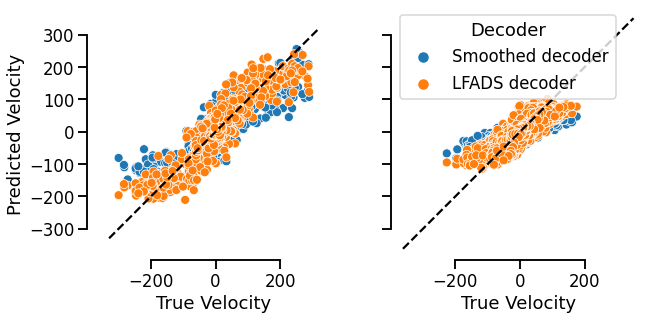

In [48]:
def plot_predicted_velocities(df,ax=None):
    pred_df = (
        df.melt(
            id_vars=[('True Velocity','')],
            value_vars=[('Smoothed decoder',''),('LFADS decoder','')],
            var_name='Decoder',
            value_name='Predicted Velocity',
            ignore_index=False,
        )
    ).rename(columns={('True Velocity',''):'True Velocity'})
    ax=sns.scatterplot(ax=ax,x='True Velocity', y='Predicted Velocity', hue='Decoder', data=pred_df)
    ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
    ax.set_aspect('equal')
    sns.despine(ax=ax,trim=True)

fig,axs = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
plot_predicted_velocities(df_co,ax=axs[0])
plot_predicted_velocities(df_cst,ax=axs[1])
axs[0].legend().remove()

In [63]:
def plot_trial_pred(trial,ax=None):
    trial_melt = (
        trial.melt(
            value_vars=[('True Velocity',''),('Smoothed decoder',''),('LFADS decoder','')],
            var_name='Decoder',
            value_name='Velocity',
            ignore_index=False,
        )
    ).reset_index()
    ax = sns.lineplot(
        ax=ax,
        data=trial_melt,
        x='Time bin (50ms)',
        y='Velocity',
        hue='Decoder',
        palette={'True Velocity':'black','Smoothed decoder':'mediumorchid','LFADS decoder':'goldenrod'},
        style='Decoder',
        dashes={'True Velocity':(7,3),'Smoothed decoder':(1,0),'LFADS decoder':(1,0)},
    )
    sns.despine(ax=ax,trim=True)

@interact(cst_trial_id=list(df_cst.groupby('trial_id').groups.keys()),co_trial_id=list(df_co.groupby('trial_id').groups.keys()))
def plot_trials(cst_trial_id,co_trial_id):
    fig,axs = plt.subplots(1,2,figsize=(10,5),sharey=True)
    plot_trial_pred(df_cst.groupby('trial_id').get_group(cst_trial_id),ax=axs[0])
    plot_trial_pred(df_co.groupby('trial_id').get_group(co_trial_id),ax=axs[1])
    axs[1].legend().remove()

interactive(children=(Dropdown(description='cst_trial_id', options=(1, 2, 3, 4, 5, 6, 9, 10, 12, 13, 14, 15, 2…

In [67]:
df_co

M1_rates                                  \
                                  0    1          2          3    4   
trial_id Time bin (50ms)                                              
11       0                 7.452829  0.0   2.762706   0.000864  0.0   
         1                15.199578  0.0   0.435810   0.039794  0.0   
         2                17.028338  0.0   0.270459   0.714170  0.0   
         3                12.237439  0.0   2.444599   5.205914  0.0   
         4                 6.138774  0.0   9.666826  16.351730  0.0   
...                             ...  ...        ...        ...  ...   
525      5                 4.529291  0.0  29.808264   0.000000  0.0   
         6                 1.998857  0.0  21.162214   0.000000  0.0   
         7                 4.526222  0.0  15.671484   0.000000  0.0   
         8                 8.301560  0.0  22.549291   0.000000  0.0   
         9                 8.794032  0.0  23.655873   0.000000  0.0   

                                                                     \
                                  5          6         7          8   
trial_id Time bin (50ms)                                              
11       0                35.342442  23.613939  3.515493  40.792047   
         1                45.108552  23.826541  7.358453  38.618237   
         2                45.730378  26.848889  6.118581  32.179617   
         3                36.019135  38.091601  2.018140  39.261463   
         4                33.212759  46.470759  0.261983  56.522053   
...                             ...        ...       ...        ...   
525      5                44.280996  24.427630  0.000000  28.683015   
         6                33.137724  23.654171  0.000000  26.191979   
         7                20.648291  26.321209  0.000000  22.132621   
         8                21.699472  31.759375  0.000610  28.721746   
         9                32.919190  37.196757  0.025942  35.672564   

                                     ... lfads_rates                      \
                                  9  ...          77        78        79   
trial_id Time bin (50ms)             ...                                   
11       0                 7.010919  ...   31.413534  2.087366  2.367400   
         1                 6.048778  ...   25.845994  2.308856  2.759480   
         2                12.207029  ...   21.859743  2.525784  3.168580   
         3                17.028448  ...   18.736992  2.375994  3.888829   
         4                15.261742  ...   13.383240  2.009038  5.337882   
...                             ...  ...         ...       ...       ...   
525      5                 6.418624  ...   15.464283  0.765887  3.312010   
         6                 8.388956  ...   13.674817  0.400596  2.104069   
         7                18.578349  ...   14.918293  0.412986  1.767618   
         8                24.546466  ...   16.358458  0.555005  1.759659   
         9                22.387883  ...   17.286831  0.785709  1.914088   

                                     hand_vel                       \
                                80          0          1         2   
trial_id Time bin (50ms)                                             
11       0                1.615682  -8.258683  16.395492  4.849133   
         1                1.618536  -1.447223  17.425280  4.148083   
         2                1.790197   8.496234   5.235132 -3.488108   
         3                1.953780  18.498176  -0.989200 -7.816321   
         4                1.839295  20.876576  -2.597164 -4.955279   
...                            ...        ...        ...       ...   
525      5                0.417890  -1.245944  39.260208 -1.608046   
         6                0.322794   0.858822  85.570686 -4.368865   
         7                0.443033  25.430339  78.642955  6.761450   
         8                0.660458  19.115646  78.506635  0.159758   
         9                0.916234   5.471122  63.098568 -1.76

: 